# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:40<00:00, 2189.92it/s]


In [25]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.

# [4] Data Splitting

In [27]:
from sklearn.cross_validation import train_test_split

#print(type(preprocessed_reviews))
#print(len(preprocessed_reviews))
Y = final["Score"].tolist()
#print(type(Y))
#print(len(Y))

X_train_cv,X_test, Y_train_cv, Y_test = train_test_split(preprocessed_reviews, Y, test_size = 0.2)

X_train, X_cv, Y_train, Y_cv = train_test_split(X_train_cv, Y_train_cv, test_size = 0.25)

#print(type(X_train_cv))
print("X training set length:" + str(len(X_train)))
#print(type(X_test))
print("Y training set length:" + str(len(Y_train)))
print("X CV set length:" + str(len(X_cv)))
print("Y cv set length:" + str(len(Y_cv)))
print("X test set length:" + str(len(X_test)))
print("Y test set length:" + str(len(Y_test)))


X training set length:52663
Y training set length:52663
X CV set length:17555
Y cv set length:17555
X test set length:17555
Y test set length:17555


# [5] Featurization

## [5.1] BAG OF WORDS

In [28]:
#BoW for training set
count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(X_train)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*127)

final_counts_train = count_vect.fit_transform(X_train)
print("the type of count vectorizer for training set: ",type(final_counts_train))
print("the shape of out text BOW vectorizer for training set: ",final_counts_train.get_shape())
print("the number of unique words for training set: ", final_counts_train.get_shape()[1])
print('#'*127)
###############################################################################################################################
#BOW for CV set
#count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(X_cv)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*127)

final_counts_cv = count_vect.transform(X_cv)
print("the type of count vectorizer for CV set: ",type(final_counts_cv))
print("the shape of out text BOW vectorizer for CV set: ",final_counts_cv.get_shape())
print("the number of unique words for CV set: ", final_counts_cv.get_shape()[1])
print('#'*127)
###############################################################################################################################
#BOW for test set
#count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(X_test)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*127)

final_counts_test = count_vect.transform(X_test)
print("the type of count vectorizer for test set: ",type(final_counts_test))
print("the shape of out text BOW vectorizer for test set: ",final_counts_test.get_shape())
print("the number of unique words for test set: ", final_counts_test.get_shape()[1])


the type of count vectorizer for training set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for training set:  (52663, 43075)
the number of unique words for training set:  43075
###############################################################################################################################
the type of count vectorizer for CV set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for CV set:  (17555, 43075)
the number of unique words for CV set:  43075
###############################################################################################################################
the type of count vectorizer for test set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for test set:  (17555, 43075)
the number of unique words for test set:  43075


## [5.1.1] BAG OF WORDS-MAX FEATURES RESTRICTED

In [29]:
#BoW for training set
count_vect = CountVectorizer(min_df=10, max_features=500) #in scikit-learn
#count_vect.fit(X_train)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*127)

final_counts_res_train = count_vect.fit_transform(X_train)
print("the type of count vectorizer for training set: ",type(final_counts_res_train))
print("the shape of out text BOW vectorizer for training set: ",final_counts_res_train.get_shape())
print("the number of unique words for training set: ", final_counts_res_train.get_shape()[1])
print('#'*127)
###############################################################################################################################
#BOW for CV set
#count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(X_cv)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*127)

final_counts_res_cv = count_vect.transform(X_cv)
print("the type of count vectorizer for CV set: ",type(final_counts_res_cv))
print("the shape of out text BOW vectorizer for CV set: ",final_counts_res_cv.get_shape())
print("the number of unique words for CV set: ", final_counts_res_cv.get_shape()[1])
print('#'*127)
###############################################################################################################################
#BOW for test set
#count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(X_test)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*127)

final_counts_res_test = count_vect.transform(X_test)
print("the type of count vectorizer for test set: ",type(final_counts_res_test))
print("the shape of out text BOW vectorizer for test set: ",final_counts_res_test.get_shape())
print("the number of unique words for test set: ", final_counts_res_test.get_shape()[1])


the type of count vectorizer for training set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for training set:  (52663, 500)
the number of unique words for training set:  500
###############################################################################################################################
the type of count vectorizer for CV set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for CV set:  (17555, 500)
the number of unique words for CV set:  500
###############################################################################################################################
the type of count vectorizer for test set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for test set:  (17555, 500)
the number of unique words for test set:  500


## [5.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [5.3] TF-IDF

In [31]:
#TF-IDFfor training Set
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*127)

final_tf_idf_train = tf_idf_vect.transform(X_train)
print("the type of count vectorizer for training set: ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer for training set: ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams for training set: ", final_tf_idf_train.get_shape()[1])
print('#'*127)
################################################################################################################################
#TF-IDFfor CV Set
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(X_cv)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*127)

final_tf_idf_cv = tf_idf_vect.transform(X_cv)
print("the type of count vectorizer for CV set: ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer for CV set: ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams for CV set: ", final_tf_idf_cv.get_shape()[1])
print('#'*127)
################################################################################################################################
#TF-IDFfor test Set
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*127)

final_tf_idf_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer for test set: ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer for test set: ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams for test set: ", final_tf_idf_test.get_shape()[1])
#print('#'*127)

some sample features(unique words in the corpus) ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer for training set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer for training set:  (52663, 31187)
the number of unique words including both unigrams and bigrams for training set:  31187
###############################################################################################################################
some sample features(unique words in the corpus) ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer for CV set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer for CV set:  (17555, 31187)
the number of unique words including both unigrams and bigrams for CV set:  31187
####################################################################

## [5.3.1] TF-IDF-MAX FEATURES RESTRICTED

In [32]:
#TF-IDFfor training Set
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*127)

final_tf_idf_res_train = tf_idf_vect.transform(X_train)
print("the type of count vectorizer for training set: ",type(final_tf_idf_res_train))
print("the shape of out text TFIDF vectorizer for training set: ",final_tf_idf_res_train.get_shape())
print("the number of unique words including both unigrams and bigrams for training set: ", final_tf_idf_res_train.get_shape()[1])
print('#'*127)
################################################################################################################################
#TF-IDFfor CV Set
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(X_cv)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*127)

final_tf_idf_res_cv = tf_idf_vect.transform(X_cv)
print("the type of count vectorizer for CV set: ",type(final_tf_idf_res_cv))
print("the shape of out text TFIDF vectorizer for CV set: ",final_tf_idf_res_cv.get_shape())
print("the number of unique words including both unigrams and bigrams for CV set: ", final_tf_idf_res_cv.get_shape()[1])
print('#'*127)
################################################################################################################################
#TF-IDFfor test Set
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
#tf_idf_vect.fit(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*127)

final_tf_idf_res_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer for test set: ",type(final_tf_idf_res_cv))
print("the shape of out text TFIDF vectorizer for test set: ",final_tf_idf_res_test.get_shape())
print("the number of unique words including both unigrams and bigrams for test set: ", final_tf_idf_res_test.get_shape()[1])
#print('#'*127)

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer for training set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer for training set:  (52663, 500)
the number of unique words including both unigrams and bigrams for training set:  500
###############################################################################################################################
some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almonds', 'almost', 'also']
the type of count vectorizer for CV set:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer for CV set:  (17555, 500)
the number of unique words including both unigrams and bigrams for CV set:  500
########################################################################################################

## [5.4] Word2Vec

In [33]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [34]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

#is_your_ram_gt_16g=False
#want_to_use_google_w2v = False
#want_to_train_w2v = True

#if want_to_train_w2v:

#training train_data
    # min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
#print(type(w2v_model))
#print(w2v_model.wv.most_similar('great'))
#print('='*50)
#print(w2v_model.wv.most_similar('worst'))
    
#print("#"*127)

list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model_cv=Word2Vec(list_of_sentance_cv,min_count=5,size=50, workers=4)
#print(w2v_model.wv.most_similar('great'))
#print('='*50)
#print(w2v_model.wv.most_similar('worst'))
    
#print("#"*127)
    
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model_test=Word2Vec(list_of_sentance_test,min_count=5,size=50, workers=4)
#print(w2v_model.wv.most_similar('great'))
#print('='*50)
#print(w2v_model.wv.most_similar('worst'))

#elif want_to_use_google_w2v and is_your_ram_gt_16g:
    #if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        #w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        #print(w2v_model.wv.most_similar('great'))
        #print(w2v_model.wv.most_similar('worst'))
    #else:
        #print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [35]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times in Training set",len(w2v_words_train))
print("sample words in training set", w2v_words_train[0:50])

print("#"*127)

w2v_words_cv = list(w2v_model_cv.wv.vocab)
print("number of words that occured minimum 5 times in CV set",len(w2v_words_cv))
print("sample words in CV set", w2v_words_cv[0:50])

print("#"*127)

w2v_words_test = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times in Test set",len(w2v_words_test))
print("sample words in test set", w2v_words_test[0:50])

number of words that occured minimum 5 times in Training set 13881
sample words in training set ['masala', 'chai', 'absolutely', 'delicious', 'definitely', 'spicy', 'average', 'american', 'vanilla', 'traditional', 'modern', 'yummy', 'spices', 'able', 'feel', 'tummy', 'warmed', 'num', 'product', 'inexpensive', 'makes', 'many', 'cups', 'small', 'package', 'need', 'amount', 'per', 'cup', 'added', 'warm', 'milk', 'no', 'complaints', 'supply', 'issues', 'since', 'day', 'baby', 'born', 'part', 'due', 'lactation', 'consultant', 'pediatrician', 'recommended', 'fenugreek', 'finally', 'tried', 'worked']
###############################################################################################################################
number of words that occured minimum 5 times in CV set 8050
sample words in CV set ['dog', 'weighs', 'little', 'big', 'awkward', 'draw', 'game', 'tug', 'war', 'though', 'slightly', 'larger', 'might', 'better', 'time', 'toy', 'seems', 'sturdy', 'screw', 'cap', 'bottom', '

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec_train = w2v_model_train.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

print("#"*127)

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_cv =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec_cv = w2v_model_cv.wv[word]
            sent_vec_cv += vec_cv
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    sent_vectors_cv.append(sent_vec_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

print("#"*127)

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_test =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec_test = w2v_model_test.wv[word]
            sent_vec_test += vec_test
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    sent_vectors_test.append(sent_vec_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|███████████████████████████████████████████████████████████| 52663/52663 [03:14<00:00, 271.19it/s]


52663
50
###############################################################################################################################


100%|███████████████████████████████████████████████████████████| 17555/17555 [00:39<00:00, 439.18it/s]


17555
50
###############################################################################################################################


100%|███████████████████████████████████████████████████████████| 17555/17555 [00:40<00:00, 436.21it/s]


17555
50


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

print("For Training Set Data")

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row_train=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec_train = np.zeros(50) # as word vectors are of zero length
    weight_sum_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec_train = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec_train += (vec_train * tf_idf_train)
            weight_sum_train += tf_idf_train
    if weight_sum_train != 0:
        sent_vec_train /= weight_sum_train
    tfidf_sent_vectors_train.append(sent_vec_train)
    row_train += 1
    
    
print("#"*127)
################################################################################################################################
print("For CV Set Data")
    
    
tf_idf_matrix_cv = model.fit_transform(X_cv)    
    
    # TF-IDF weighted Word2Vec

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row_cv=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    weight_sum_cv =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv and word in tfidf_feat:
            vec_cv = w2v_model_cv.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_cv = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec_cv += (vec_cv * tf_idf_cv)
            weight_sum_cv += tf_idf_cv
    if weight_sum_cv != 0:
        sent_vec_cv /= weight_sum_cv
    tfidf_sent_vectors_cv.append(sent_vec_cv)
    row_cv += 1
    
print("#"*127)

################################################################################################################################
print("For Test Set Data")


tf_idf_matrix_test = model.fit_transform(X_test)    
    
    # TF-IDF weighted Word2Vec

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row_test=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    weight_sum_test =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec_test = w2v_model_test.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec_test += (vec_test * tf_idf_test)
            weight_sum_test += tf_idf_test
    if weight_sum_test != 0:
        sent_vec_test /= weight_sum_test
    tfidf_sent_vectors_test.append(sent_vec_test)
    row_test += 1
    


For Training Set Data


100%|████████████████████████████████████████████████████████████████████████████| 52663/52663 [32:43<00:00, 26.82it/s]


###############################################################################################################################
For CV Set Data


100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [12:06<00:00, 24.41it/s]


###############################################################################################################################
For Test Set Data


100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [09:05<00:00, 32.17it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [1]:

from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable
import seaborn as sns; sns.set()



C:\Users\4bhishek\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training dataset for Best 'K'


100%|███████████████████████████████████████████████████████████████| 17/17 [1:03:41<00:00, 203.56s/it]


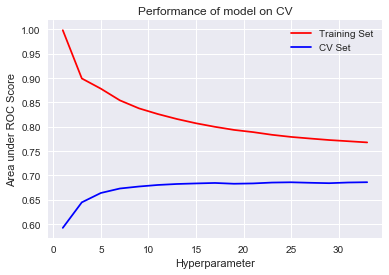

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9985477941718331 | 0.5923548450410385 |
|       3        | 0.8993583036641923 | 0.6448152774124427 |
|       5        | 0.8783931840152769 | 0.6640403091973937 |
|       7        | 0.8543990063344005 | 0.6732186761397381 |
|       9        | 0.8379782345657463 | 0.6773293800930617 |
|       11       | 0.8262075318469405 | 0.6805180706837363 |
|       13       | 0.8160372007436028 | 0.6825333432157935 |
|       15       | 0.8072953369689168 | 0.6836703505250352 |
|       17       | 0.7999962144276699 | 0.6846319689838057 |
|       19       | 0.7936495158596892 | 0.6830187638329624 |
|       21       | 0.7891326256610178 | 0.6836907655230361 |
|       23       | 0.7835833537217806 | 0.685471998116248  |
|       25       | 0.7792448129758638 | 0.6860398112635836 |
|       27       | 0.775

In [57]:
# Please write all the code with proper documentation

hyperparameter_BOW = []

auc_scoresBOW_train = []

auc_scoresBOW_cv = []

table1_BOW = PrettyTable()

table1_BOW.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]

print("Training dataset for Best 'K'")

for i in tqdm(range(1,35,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i)
    
    knn.fit(final_counts_train, Y_train)
    
    #print(final_counts_train.shape[0])
    #print(final_counts_train[0:3000].shape)
       
    BOWpred_train = []
   
    for k in range(0,final_counts_train.shape[0],3000):
    
       BOWpred_train.extend(knn.predict_proba(final_counts_train[k:k+3000])[:,1])
        
    BOWpred_cv = []    
    
    for l in range(0,final_counts_cv.shape[0],3000):
    
        BOWpred_cv.extend(knn.predict_proba(final_counts_cv[l:l+3000])[:,1])
    
    hyperparameter_BOW.append(i)
    
    auc_scoreBOW_train = roc_auc_score(Y_train, BOWpred_train)
    auc_scoresBOW_train.append(auc_scoreBOW_train)
    
    auc_scoreBOW_cv = roc_auc_score(Y_cv, BOWpred_cv)
    auc_scoresBOW_cv.append(auc_scoreBOW_cv)
    
    table1_BOW.add_row([i,auc_scoreBOW_train, auc_scoreBOW_cv])

    
plt.plot(hyperparameter_BOW, auc_scoresBOW_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_BOW, auc_scoresBOW_cv, 'blue', label = 'CV Set')
plt.title("Performance of model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_BOW)



In [58]:
print("from the plot the optimal K is 33")
print("AUC for training set for K = 33: " + str(auc_scoresBOW_train[16]))
print("AUC for CV set for K = 33: " + str(auc_scoresBOW_cv[16]))


knn = KNeighborsClassifier(n_neighbors = 33)

knn.fit(final_counts_train, Y_train)

BOWpred_train = []
BOWpred_train_val = []

print("\nPredict for training Data")
for m in tqdm(range(0,final_counts_train.shape[0],3000)):
    
       BOWpred_train.extend(knn.predict_proba(final_counts_train[m:m+3000])[:,1])
       BOWpred_train_val.extend(knn.predict(final_counts_train[m:m+3000]))

#knn.predict(final_counts_train)

BOWpred_test = []
BOWpred_test_val = []

print("Predict for Test Data")

for n in tqdm(range(0,final_counts_test.shape[0],3000)):
    
        BOWpred_test.extend(knn.predict_proba(final_counts_test[n:n+3000])[:,1])
        BOWpred_test_val.extend(knn.predict(final_counts_test[n:n+3000]))    

#knn.predict(final_counts_test)

BOWfpr_train, BOWtpr_train, BOWthrshold_train = roc_curve(Y_train, BOWpred_train)

BOWfpr_test, BOWtpr_test, BOWthrshold_test = roc_curve(Y_test, BOWpred_test)




from the plot the optimal K is 33
AUC for training set for K = 33: 0.7679618728202253
AUC for CV set for K = 33: 0.686184277396495

Predict for training Data


100%|██████████████████████████████████████████████████████████████████| 18/18 [04:05<00:00, 11.96s/it]


Predict for Test Data


100%|████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.26s/it]


AUC of test data for K = 33 is 0.6861794145375679
AUC of test data for K = 33 is 0.7679618728202253


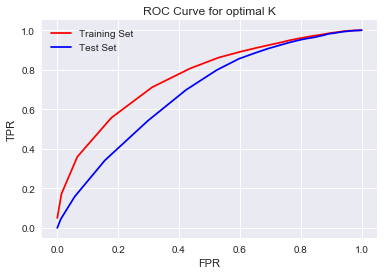

Confusion Matrix on training Data
[[ 1014  7519]
 [  819 43311]]


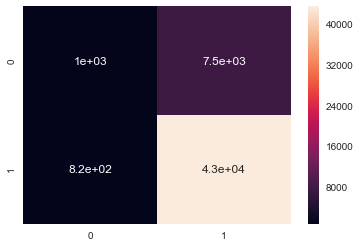

In [67]:
auc_scoreBOW_test = roc_auc_score(Y_test, BOWpred_test)

print("AUC of test data for K = 33 is " + str(auc_scoreBOW_test))
print("AUC of train data for K = 33 is " + str(auc_scoreBOW_train))

plt.plot(BOWfpr_train,BOWtpr_train,'r', label="Training Set")
plt.plot(BOWfpr_test,BOWtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

plt.subplot()
cm_train = confusion_matrix(Y_train,BOWpred_train_val)


print("Confusion Matrix on training Data")
print(cm_train)
sns.heatmap(cm_train, annot = True)

#table2_BOW = PrettyTable()

#table2_BOW.field_names = ["     ", "Predicted: NO", "Predicted: Yes"]

#table2_BOW.add_row(["Actual:NO", cm[0][0], cm[0][1]])
#table2_BOW.add_row(["Actual: Yes", cm[1][0], cm[1][1]])
#print(table2_BOW)

Confusion Matrix on training Data
[[  310  2511]
 [  270 14464]]
AxesSubplot(0.125,0.125;0.62x0.755)


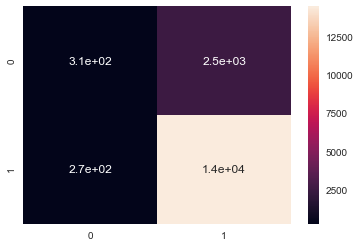

In [62]:
cm_test = confusion_matrix(Y_test,BOWpred_test_val)

print("Confusion Matrix on training Data")
print(cm_test)

print(sns.heatmap(cm_test, annot = True))


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

100%|█████████████████████████████████████████████████████████████████| 16/16 [49:18<00:00, 181.76s/it]


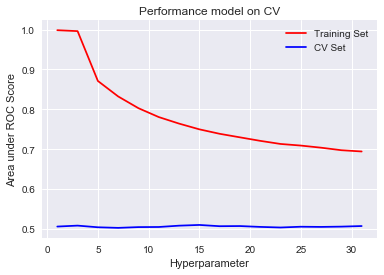

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9985364640109449 | 0.5057673330057967 |
|       3        | 0.9961886894959385 | 0.508136829770812  |
|       5        | 0.8711459972425736 | 0.5039532322658035 |
|       7        |  0.83228261593219  | 0.5024626732176554 |
|       9        | 0.8028002626079808 | 0.5043866066468927 |
|       11       | 0.7805564055721181 | 0.5046606239553525 |
|       13       | 0.7641499568370398 | 0.5080030995250847 |
|       15       | 0.7497620533432949 | 0.5098018529901103 |
|       17       | 0.7385582145206693 | 0.5066418274583933 |
|       19       | 0.7296733660541689 | 0.5070212101741818 |
|       21       | 0.7208632199023963 | 0.5048912653974719 |
|       23       | 0.7130575503392821 | 0.5033863317889667 |
|       25       | 0.7090197481530829 | 0.5053334062188791 |
|       27       | 0.703

In [64]:
# Please write all the code with proper documentation


hyperparameter_TFIDF = []

auc_scoresTFIDF_train = []


auc_scoresTFIDF_cv = []

table1_TFIDF = PrettyTable()

table1_TFIDF.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]

#print(type(final_tf_idf_train))
#print(str(final_tf_idf_train.get_shape()))

# Cross Validation loop to get optimal K.

for i in tqdm(range(1,33,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i)
    
    knn.fit(final_tf_idf_train, Y_train)
       
    TFIDFpred_train = []
    
    for k in range(0,final_tf_idf_train.shape[0],3000):
            TFIDFpred_train.extend(knn.predict_proba(final_tf_idf_train[k:k+3000])[:,1])
        
    TFIDFpred_cv = []
    
    for l in range(0,final_tf_idf_cv.shape[0],3000):
        TFIDFpred_cv.extend(knn.predict_proba(final_tf_idf_cv[l:l+3000])[:,1])
    
    hyperparameter_TFIDF.append(i)
    
    auc_scoreTFIDF_train = roc_auc_score(Y_train, TFIDFpred_train)
    auc_scoresTFIDF_train.append(auc_scoreTFIDF_train)
    
    auc_scoreTFIDF_cv = roc_auc_score(Y_cv, TFIDFpred_cv)
    auc_scoresTFIDF_cv.append(auc_scoreTFIDF_cv)
    
    table1_TFIDF.add_row([i,auc_scoreTFIDF_train, auc_scoreTFIDF_cv])

    
plt.plot(hyperparameter_TFIDF, auc_scoresTFIDF_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_TFIDF, auc_scoresTFIDF_cv, 'blue', label = 'CV Set')
plt.title("Performance model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_TFIDF)


In [65]:
print("from the plot the optimal K is 31")
print("AUC for training set for K = 31: " + str(auc_scoresTFIDF_train[15]))
print("AUC for CV set for K = 31: " + str(auc_scoresTFIDF_cv[15]))


#Predicting Y for K = 31 for test dataset.

knn = KNeighborsClassifier(n_neighbors = 31)

knn.fit(final_tf_idf_train, Y_train)

TFIDFpred_train = []
TFIDFpred_train_val = []

print("Predicting training data")

for m in tqdm(range(0, final_tf_idf_train.shape[0],3000)):
   TFIDFpred_train.extend(knn.predict_proba(final_tf_idf_train[m:m+3000])[:,1])
   TFIDFpred_train_val.extend(knn.predict(final_tf_idf_train[m:m+3000]))


TFIDFpred_test = []
TFIDFpred_test_val = []

print("Predicting test data")
for n in tqdm(range(0,final_tf_idf_test.shape[0],3000)):
    TFIDFpred_test.extend(knn.predict_proba(final_tf_idf_test[n:n+3000])[:,1])
    TFIDFpred_test_val.extend(knn.predict(final_tf_idf_test[n:n+3000]))

              
TFIDFfpr_train, TFIDFtpr_train, TFIDFthrshold_train = roc_curve(Y_train, TFIDFpred_train)

TFIDFfpr_test, TFIDFtpr_test, TFIDFthrshold_test = roc_curve(Y_test, TFIDFpred_test)




from the plot the optimal K is 31
AUC for training set for K = 31: 0.6941582232204483
AUC for CV set for K = 31: 0.5070461645070321
Predicting training data


100%|██████████████████████████████████████████████████████████████████| 18/18 [04:40<00:00, 13.27s/it]


Predicting test data


100%|████████████████████████████████████████████████████████████████████| 6/6 [01:30<00:00, 14.61s/it]


AUC for test data for K = 31 = 0.5002480114455051
AUC for test data for K = 31 = 0.6941582232204483


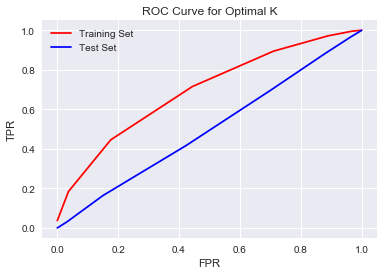

Confusion Matrix on training Data
[[    0  8533]
 [    0 44130]]


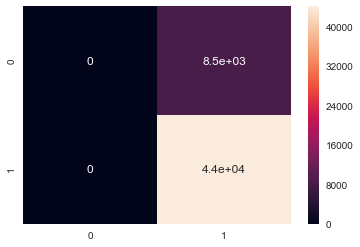

In [69]:

auc_scoreTFIDF_test = roc_auc_score(Y_test, TFIDFpred_test)

#print("AUC for test data for k = 31 = " + str(auc_scoreTFIDF_test))

auc_scoreTFIDF_train = roc_auc_score(Y_train, TFIDFpred_train)

#print("AUC for train data for k = 31 = " + str(auc_scoreTFIDF_train))

print("AUC for test data for K = 31 = " + str(auc_scoreTFIDF_test))
print("AUC for train data for K = 31 = " + str(auc_scoreTFIDF_train))

plt.plot(TFIDFfpr_train,TFIDFtpr_train,'r', label="Training Set")
plt.plot(TFIDFfpr_test,TFIDFtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for Optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

cm_train = confusion_matrix(Y_train,TFIDFpred_train_val)


print("Confusion Matrix on training Data")
print(cm_train)
sns.heatmap(cm_train, annot = True)

Confusion Matrix on training Data
[[    0  2821]
 [    0 14734]]
AxesSubplot(0.125,0.125;0.62x0.755)


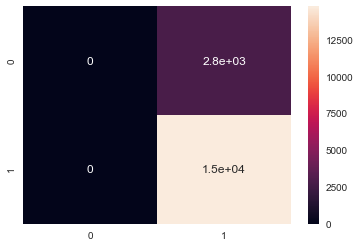

In [70]:
cm_test = confusion_matrix(Y_test,TFIDFpred_test_val)

print("Confusion Matrix on training Data")
print(cm_test)

print(sns.heatmap(cm_test, annot = True))

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

100%|███████████████████████████████████████████████████████████████| 17/17 [2:31:30<00:00, 565.89s/it]


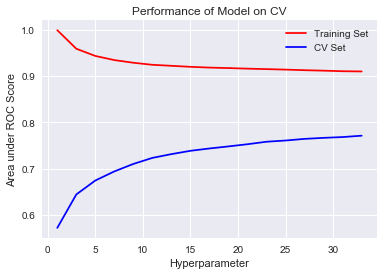

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9992855173722185 | 0.5716731671222655 |
|       3        | 0.959162588114142  | 0.6439817690705383 |
|       5        | 0.9435547650158093 | 0.6741418663669777 |
|       7        | 0.9346274745872046 | 0.693844957360995  |
|       9        |  0.92885501720052  | 0.7100061662901019 |
|       11       | 0.9244302076296796 | 0.7230729058487192 |
|       13       | 0.9222576423083743 | 0.7312138066103091 |
|       15       | 0.9200545826152234 | 0.738379338811534  |
|       17       | 0.9183876056405053 | 0.7434336840165647 |
|       19       | 0.917340163934535  | 0.7478998611203713 |
|       21       | 0.9161109457108562 | 0.7526206132492472 |
|       23       | 0.9150870499726618 | 0.7580112895419296 |
|       25       | 0.9140351667586438 | 0.7606446321428716 |
|       27       | 0.912

In [71]:
# Please write all the code with proper documentation

hyperparameter_Avg_W2V = []

auc_scoresAvg_W2V_train = []


auc_scoresAvg_W2V_cv = []

table1_Avg_W2V = PrettyTable()

table1_Avg_W2V.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]

#print(type(sent_vectors_train))
#print(str(len(sent_vectors_train)))

#running Cross Validation for optimal K

for i in tqdm(range(1,34,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i)
    
    knn.fit(sent_vectors_train, Y_train)
    
    Avg_W2Vpred_train = []
    
    for k in range(0,len(sent_vectors_train), 3000):
        
        Avg_W2Vpred_train.extend(knn.predict_proba(sent_vectors_train[k:k+3000])[:,1])
        
    Avg_W2Vpred_cv = []
    
    for l in range(0,len(sent_vectors_cv), 3000):
        
        Avg_W2Vpred_cv.extend(knn.predict_proba(sent_vectors_cv[l:l+3000])[:,1])
    
    hyperparameter_Avg_W2V.append(i)
    
    auc_scoreAvg_W2V_train = roc_auc_score(Y_train, Avg_W2Vpred_train)
    auc_scoresAvg_W2V_train.append(auc_scoreAvg_W2V_train)
    
    auc_scoreAvg_W2V_cv = roc_auc_score(Y_cv, Avg_W2Vpred_cv)
    auc_scoresAvg_W2V_cv.append(auc_scoreAvg_W2V_cv)
    
    table1_Avg_W2V.add_row([i,auc_scoreAvg_W2V_train, auc_scoreAvg_W2V_cv])

    
plt.plot(hyperparameter_Avg_W2V, auc_scoresAvg_W2V_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_Avg_W2V, auc_scoresAvg_W2V_cv, 'blue', label = 'CV Set')
plt.title("Performance of Model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_Avg_W2V)




In [72]:
print("from the plot the optimal K is 33")
print("AUC for training set for K = 33: " + str(auc_scoresAvg_W2V_train[16]))
print("AUC for CV set for K = 33: " + str(auc_scoresAvg_W2V_cv[16]))



knn = KNeighborsClassifier(n_neighbors = 33)

knn.fit(sent_vectors_train, Y_train)

Avg_W2Vpred_train = []
Avg_W2Vpred_train_val = []

for m in tqdm(range(0, len(sent_vectors_train),3000)):
    
    Avg_W2Vpred_train.extend(knn.predict_proba(sent_vectors_train[m:m+3000])[:,1])
    Avg_W2Vpred_train_val.extend(knn.predict(sent_vectors_train[m:m+3000]))

Avg_W2Vpred_test = []
Avg_W2Vpred_test_val = []

for n in tqdm(range(0, len(sent_vectors_test),3000)):

    Avg_W2Vpred_test.extend(knn.predict_proba(sent_vectors_test[n:n+3000])[:,1])
    Avg_W2Vpred_test_val.extend(knn.predict(sent_vectors_test[n:n+3000]))

    
Avg_W2Vfpr_train, Avg_W2Vtpr_train, Avg_W2Vthrshold_train = roc_curve(Y_train, Avg_W2Vpred_train)

Avg_W2Vfpr_test, Avg_W2Vtpr_test, Avg_W2Vthrshold_test = roc_curve(Y_test, Avg_W2Vpred_test)





from the plot the optimal K is 33
AUC for training set for K = 33: 0.9100546474121118
AUC for CV set for K = 33: 0.7710784133828622


100%|████████████████████████████████████████████████████████████████████| 6/6 [06:23<00:00, 61.72s/it]


AUC for test dataset for k=33 = 0.7522072381088394
AUC for train dataset for k=33 = 0.9100546474121118


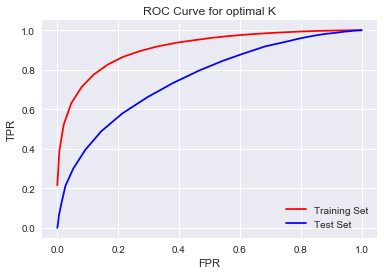

Confusion Matrix on training Data
[[ 2616  5917]
 [  648 43482]]


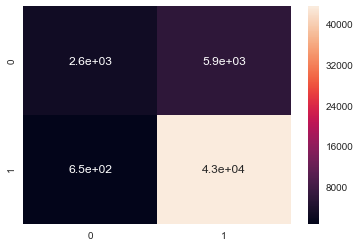

In [74]:
auc_scoreAvg_W2V_test = roc_auc_score(Y_test, Avg_W2Vpred_test)

print("AUC for test dataset for k=33 = " + str(auc_scoreAvg_W2V_test))

auc_scoreAvg_W2V_train = roc_auc_score(Y_train, Avg_W2Vpred_train)

print("AUC for train dataset for k=33 = " + str(auc_scoreAvg_W2V_train))

plt.plot(Avg_W2Vfpr_train,Avg_W2Vtpr_train,'r', label="Training Set")
plt.plot(Avg_W2Vfpr_test,Avg_W2Vtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


cm_train = confusion_matrix(Y_train,Avg_W2Vpred_train_val)


print("Confusion Matrix on training Data")
print(cm_train)
sns.heatmap(cm_train, annot = True)


Confusion Matrix on training Data
[[  444  2377]
 [  407 14327]]
AxesSubplot(0.125,0.125;0.62x0.755)


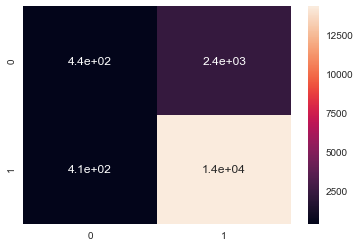

In [75]:
cm_test = confusion_matrix(Y_test,Avg_W2Vpred_test_val)

print("Confusion Matrix on training Data")
print(cm_test)

print(sns.heatmap(cm_test, annot = True))

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [76]:
# Please write all the code with proper documentation

hyperparameter_TFIDF_W2V = []

auc_scoresTFIDF_W2V_train = []


auc_scoresTFIDF_W2V_cv = []

table1_TFIDF_W2V = PrettyTable()

table1_TFIDF_W2V.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]

#print(type(tfidf_sent_vectors_train))
#print(str(len(tfidf_sent_vectors_train)))

#Running cross Validation for optimal K.

for i in tqdm(range(1,34,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i)
    
    knn.fit(tfidf_sent_vectors_train, Y_train)
       
    TFIDF_W2Vpred_train = []
    
    for k in range(0,len(tfidf_sent_vectors_train),3000):
    
        TFIDF_W2Vpred_train.extend(knn.predict_proba(tfidf_sent_vectors_train[k:k+3000])[:,1])
    
    
        
    TFIDF_W2Vpred_cv = []
    
    for l in range(0,len(tfidf_sent_vectors_cv),3000):
    
        TFIDF_W2Vpred_cv.extend(knn.predict_proba(tfidf_sent_vectors_cv[l:l+3000])[:,1])
    
    hyperparameter_TFIDF_W2V.append(i)
    
    auc_scoreTFIDF_W2V_train = roc_auc_score(Y_train, TFIDF_W2Vpred_train)
    auc_scoresTFIDF_W2V_train.append(auc_scoreTFIDF_W2V_train)
    
    auc_scoreTFIDF_W2V_cv = roc_auc_score(Y_cv, TFIDF_W2Vpred_cv)
    auc_scoresTFIDF_W2V_cv.append(auc_scoreTFIDF_W2V_cv)
    
    table1_TFIDF_W2V.add_row([i,auc_scoreTFIDF_W2V_train, auc_scoreTFIDF_W2V_cv])

    


100%|███████████████████████████████████████████████████████████████| 17/17 [3:36:25<00:00, 590.85s/it]


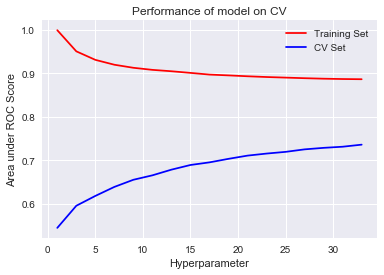

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.999238251494199  | 0.5448652365151974 |
|       3        | 0.9506342247765298 | 0.5957070237392322 |
|       5        | 0.9310578498389996 | 0.6183013828206975 |
|       7        | 0.9198552538419443 |  0.63901198999252  |
|       9        | 0.9128379725382818 | 0.655433430102025  |
|       11       | 0.9080677849281853 | 0.6656380950203353 |
|       13       | 0.9048739303500898 | 0.6786861728690153 |
|       15       | 0.9011084184994161 | 0.6893949561408989 |
|       17       | 0.8971880580183905 | 0.695435994225774  |
|       19       | 0.8953584010188621 | 0.7035527932809006 |
|       21       | 0.8933219025248187 | 0.7109472856891152 |
|       23       | 0.891608942331805  | 0.7156572538955178 |
|       25       | 0.8902589137614224 | 0.7195776780586519 |
|       27       | 0.888

In [77]:
plt.plot(hyperparameter_TFIDF_W2V, auc_scoresTFIDF_W2V_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_TFIDF_W2V, auc_scoresTFIDF_W2V_cv, 'blue', label = 'CV Set')
plt.title("Performance of model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_TFIDF_W2V)




In [78]:
print("from the plot the optimal K is 31")
print("AUC for training set for K = 31: " + str(auc_scoresTFIDF_W2V_train[15]))
print("AUC for CV set for K = 31: " + str(auc_scoresTFIDF_W2V_cv[15]))



knn = KNeighborsClassifier(n_neighbors = 29)

knn.fit(tfidf_sent_vectors_train, Y_train)

TFIDF_W2Vpred_train = []
TFIDF_W2Vpred_train_val = []


for m in tqdm(range(0,len(tfidf_sent_vectors_train),3000)):

    TFIDF_W2Vpred_train.extend(knn.predict_proba(tfidf_sent_vectors_train[m:m+3000])[:,1])
    TFIDF_W2Vpred_train_val.extend(knn.predict(tfidf_sent_vectors_train[m:m+3000]))


TFIDF_W2Vpred_test = []
TFIDF_W2Vpred_test_val = []                
                                   
for n in tqdm(range(0,len(tfidf_sent_vectors_test),3000)):               

   TFIDF_W2Vpred_test.extend(knn.predict_proba(tfidf_sent_vectors_test[n:n+3000])[:,1])
   TFIDF_W2Vpred_test_val.extend(knn.predict(tfidf_sent_vectors_test[n:n+3000]))

                             
        
TFIDF_W2Vfpr_train, TFIDF_W2Vtpr_train, TFIDF_W2Vthrshold_train = roc_curve(Y_train, TFIDF_W2Vpred_train)

TFIDF_W2Vfpr_test, TFIDF_W2Vtpr_test, TFIDF_W2Vthrshold_test = roc_curve(Y_test, TFIDF_W2Vpred_test)


from the plot the optimal K is 31
AUC for training set for K = 31: 0.8869922304015901
AUC for CV set for K = 31: 0.7313953199601806


100%|████████████████████████████████████████████████████████████████████| 6/6 [05:34<00:00, 54.76s/it]


AUC value of train data for k = = 0.8877589422428418
AUC value of test data for k = = 0.7471076358365796


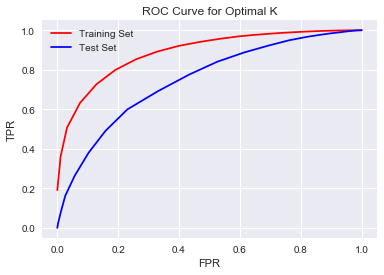

In [79]:
auc_scoreTFIDF_W2V_train = roc_auc_score(Y_train, TFIDF_W2Vpred_train)
print("AUC value of train data for k = = " + str(auc_scoreTFIDF_W2V_train))

auc_scoreTFIDF_W2V_test = roc_auc_score(Y_test, TFIDF_W2Vpred_test)
print("AUC value of test data for k = = " + str(auc_scoreTFIDF_W2V_test))


plt.plot(TFIDF_W2Vfpr_train,TFIDF_W2Vtpr_train,'r', label="Training Set")
plt.plot(TFIDF_W2Vfpr_test,TFIDF_W2Vtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for Optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


Confusion Matrix on training Data
[[ 2189  6344]
 [  568 43562]]
AxesSubplot(0.125,0.125;0.62x0.755)


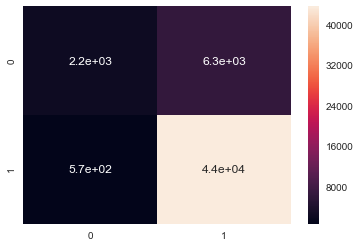

In [80]:
cm_train = confusion_matrix(Y_train,TFIDF_W2Vpred_train_val)

print("Confusion Matrix on training Data")
print(cm_train)

print(sns.heatmap(cm_train, annot = True))

Confusion Matrix on test Data
[[ 2189  6344]
 [  568 43562]]
AxesSubplot(0.125,0.125;0.62x0.755)


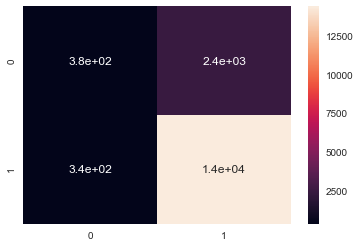

In [81]:
cm_test = confusion_matrix(Y_test,TFIDF_W2Vpred_test_val)

print("Confusion Matrix on test Data")
print(cm_train)

print(sns.heatmap(cm_test, annot = True))

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

100%|█████████████████████████████████████████████████████████████| 17/17 [16:12:30<00:00, 3663.46s/it]


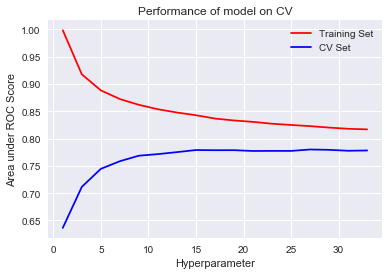

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9983419060413778 | 0.6364518771902891 |
|       3        | 0.9175432145454994 | 0.711487922871465  |
|       5        | 0.8881598623692839 | 0.7445254300743568 |
|       7        | 0.8722958246717288 | 0.7585012975292377 |
|       9        | 0.8617293827520083 | 0.7685762911837759 |
|       11       | 0.8536263339760707 | 0.771465926071384  |
|       13       | 0.8476221838946854 | 0.7751127292171957 |
|       15       | 0.8427137691184348 | 0.7789411898187475 |
|       17       | 0.8365703203321828 | 0.7786280958023497 |
|       19       | 0.8330872844099296 | 0.7786977709896442 |
|       21       | 0.830494516576571  | 0.777225429325006  |
|       23       | 0.8271218942871159 | 0.7773810156274168 |
|       25       | 0.8248349505069945 | 0.7773358384377234 |
|       27       | 0.822

In [83]:
# Please write all the code with proper documentation


hyperparameter_BOW_Kd = []

auc_scoresBOW_Kd_train = []


auc_scoresBOW_Kd_cv = []

table1_BOW_Kd = PrettyTable()

table1_BOW_Kd.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]
#print(type(final_counts_res_train))
#print(str(len(final_counts_res_train)))

#Running Cross Validation for optimal K

for i in tqdm(range(1,35,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i, algorithm = 'kd_tree')
    
    knn.fit(final_counts_res_train.toarray(), Y_train)
     
    BOW_Kdpred_train = []
    
    #for k in range(0,len(final_counts_res_train.toarray()),10000):
    
        #BOW_Kdpred_train.extend(knn.predict_proba(final_counts_res_train.toarray()[k:k+10000])[:,1])
    BOW_Kdpred_train = knn.predict_proba(final_counts_res_train.toarray())[:,1]
        
    BOW_Kdpred_cv = []
    
    #for l in range(0,len(final_counts_res_cv.toarray()),10000):
    
        #BOW_Kdpred_cv.extend(knn.predict_proba(final_counts_res_cv.toarray()[l:l+10000])[:,1])
    BOW_Kdpred_cv = knn.predict_proba(final_counts_res_cv.toarray())[:,1]
    
    hyperparameter_BOW_Kd.append(i)
    
    auc_scoreBOW_Kd_train = roc_auc_score(Y_train, BOW_Kdpred_train)
    auc_scoresBOW_Kd_train.append(auc_scoreBOW_Kd_train)
    
    auc_scoreBOW_Kd_cv = roc_auc_score(Y_cv, BOW_Kdpred_cv)
    auc_scoresBOW_Kd_cv.append(auc_scoreBOW_Kd_cv)
    
    table1_BOW_Kd.add_row([i,auc_scoreBOW_Kd_train, auc_scoreBOW_Kd_cv])

    
plt.plot(hyperparameter_BOW_Kd, auc_scoresBOW_Kd_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_BOW_Kd, auc_scoresBOW_Kd_cv, 'blue', label = 'CV Set')
plt.title("Performance of model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_BOW_Kd)




In [84]:
print("from the plot the optimal K is 33")
print("AUC for training set for K = 33: " + str(auc_scoresBOW_Kd_train[16]))
print("AUC for CV set for K =33: " + str(auc_scoresBOW_Kd_cv[16]))



knn = KNeighborsClassifier(n_neighbors = 33)

knn.fit(final_counts_res_train.toarray(), Y_train)

BOW_Kdpred_train = []
BOW_Kdpred_train_val = []

#for m in tqdm(range(0,len(final_counts_res_train.toarray()),3000)):

    #BOW_Kdpred_train.extend(knn.predict_proba(final_counts_res_train.toarray()[m:m+3000])[:,1])
    #BOW_Kdpred_train_val.extend(knn.predict(final_counts_res_train.toarray()[m:m+3000]))

BOW_Kdpred_train = knn.predict_proba(final_counts_res_train.toarray())[:,1]
BOW_Kdpred_train_val = knn.predict(final_counts_res_train.toarray())
    
BOW_Kdpred_test = []
BOW_Kdpred_test_val = []

#for n in tqdm(range(0,len(final_counts_res_test.toarray()),3000)):

#    BOW_Kdpred_test.extend(knn.predict_proba(final_counts_res_test.toarray()[n:n+3000])[:,1])
#    BOW_Kdpred_test_val.extend(knn.predict(final_counts_res_test.toarray()[n:n+3000]))

BOW_Kdpred_test = knn.predict_proba(final_counts_res_test.toarray())[:,1]
BOW_Kdpred_test_val = knn.predict(final_counts_res_test.toarray())
    
    
BOW_Kdfpr_train, BOW_Kdtpr_train, BOW_Kdthrshold_train = roc_curve(Y_train, BOW_Kdpred_train)

BOW_Kdfpr_test, BOW_Kdtpr_test, BOW_Kdthrshold_test = roc_curve(Y_test, BOW_Kdpred_test)



from the plot the optimal K is 33
AUC for training set for K = 33: 0.8168027653612512
AUC for CV set for K =33: 0.778143900085061


AUC of Train data for k = = 0.8168027653612512
AUC of Test data for k = = 0.7751633877798072


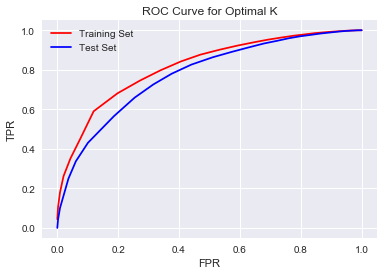

Confusion Matrix on training Data
[[ 2250  6283]
 [ 1625 42505]]
AxesSubplot(0.125,0.125;0.62x0.755)


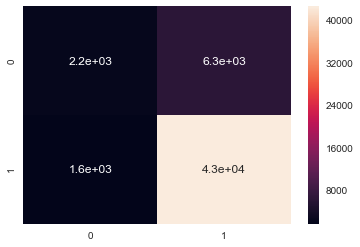

In [85]:
auc_scoreBOW_Kd_train = roc_auc_score(Y_train, BOW_Kdpred_train)
print("AUC of Train data for k = = " + str(auc_scoreBOW_Kd_train))

auc_scoreBOW_Kd_test = roc_auc_score(Y_test, BOW_Kdpred_test)
print("AUC of Test data for k = = " + str(auc_scoreBOW_Kd_test))

plt.plot(BOW_Kdfpr_train,BOW_Kdtpr_train,'r', label="Training Set")
plt.plot(BOW_Kdfpr_test,BOW_Kdtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for Optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

cm_train = confusion_matrix(Y_train,BOW_Kdpred_train_val)


print("Confusion Matrix on training Data")
print(cm_train)

print(sns.heatmap(cm_train, annot = True))


Confusion Matrix on training Data
[[  678  2143]
 [  602 14132]]
AxesSubplot(0.125,0.125;0.62x0.755)


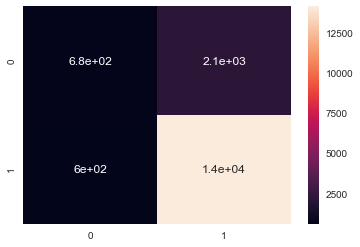

In [86]:
cm_test = confusion_matrix(Y_test,BOW_Kdpred_test_val)


print("Confusion Matrix on training Data")
print(cm_test)

print(sns.heatmap(cm_test, annot = True))


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

100%|█████████████████████████████████████████████████████████████| 17/17 [16:49:10<00:00, 3544.75s/it]


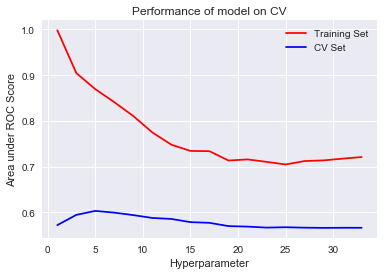

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9983419060413778 | 0.5718118329939801 |
|       3        | 0.9045181144349702 | 0.5942768810763441 |
|       5        | 0.8693079936602087 | 0.6029732258982455 |
|       7        | 0.840796580551336  | 0.5991484399963339 |
|       9        | 0.8103914013572665 | 0.5937064259880908 |
|       11       | 0.7745330009890289 | 0.5875135723710238 |
|       13       | 0.7477951557367992 | 0.5853455596274537 |
|       15       | 0.7342195237327767 | 0.5783702351634843 |
|       17       | 0.7336125375499962 | 0.5768588888438425 |
|       19       | 0.7131899696859441 | 0.5697180587901987 |
|       21       | 0.7156173779838071 | 0.568615889074604  |
|       23       | 0.7102648150583932 | 0.5664178542751502 |
|       25       | 0.7045746390979275 | 0.5672347784333847 |
|       27       | 0.712

In [89]:
# Please write all the code with proper documentation


hyperparameter_TFIDF_kd = []

auc_scoresTFIDF_kd_train = []


auc_scoresTFIDF_kd_cv = []

table1_TFIDF_kd = PrettyTable()

table1_TFIDF_kd.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]
#print(type(final_tf_idf_res_train))
#print(str(len(final_tf_idf_res_train)))


#running Cross validation to get optimal K

for i in tqdm(range(1,35,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i, algorithm = 'kd_tree')
    
    knn.fit(final_tf_idf_res_train.toarray(), Y_train)
       
    TFIDF_kdpred_train = []
    
#    for k in range(0,len(final_tf_idf_res_train.toarray()),3000):
    
#        TFIDF_kdpred_train.extend(knn.predict_proba(final_tf_idf_res_train.toarray()[k:k+3000])[:,1])
        
    TFIDF_kdpred_train = knn.predict_proba(final_tf_idf_res_train.toarray())[:,1]
        
    TFIDF_kdpred_cv = []
    
#    for l in range(0, len(final_tf_idf_res_cv.toarray()), 3000):
    
#        TFIDF_kdpred_cv.extend(knn.predict_proba(final_tf_idf_res_cv.toarray()[l:l+3000])[:,1])
        
    TFIDF_kdpred_cv = knn.predict_proba(final_tf_idf_res_cv.toarray())[:,1]
    
    hyperparameter_TFIDF_kd.append(i)
    
    auc_scoreTFIDF_kd_train = roc_auc_score(Y_train, TFIDF_kdpred_train)
    auc_scoresTFIDF_kd_train.append(auc_scoreTFIDF_kd_train)
    
    auc_scoreTFIDF_kd_cv = roc_auc_score(Y_cv, TFIDF_kdpred_cv)
    auc_scoresTFIDF_kd_cv.append(auc_scoreTFIDF_kd_cv)
    
    table1_TFIDF_kd.add_row([i,auc_scoreTFIDF_kd_train, auc_scoreTFIDF_kd_cv])

    
plt.plot(hyperparameter_TFIDF_kd, auc_scoresTFIDF_kd_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_TFIDF_kd, auc_scoresTFIDF_kd_cv, 'blue', label = 'CV Set')
plt.title("Performance of model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_TFIDF_kd)


In [90]:
print("from the plot the optimal K is 25")
print("AUC for training set for K = 25: " + str(auc_scoresTFIDF_kd_train[12]))
print("AUC for CV set for K =25: " + str(auc_scoresTFIDF_kd_cv[12]))



knn = KNeighborsClassifier(n_neighbors = 25, algorithm = 'kd_tree')

knn.fit(final_tf_idf_res_train.toarray(), Y_train)

TFIDF_kdpred_train = []
TFIDF_kdpred_train_val = []

#for m in range(0,len(final_tf_idf_res_train.toarray()), 3000):

#    TFIDF_kdpred_train.extend(knn.predict_proba(final_tf_idf_res_train.toarray()[m:m+3000])[:,1])
#    TFIDF_kdpred_train_val.extend(knn.predict(final_tf_idf_res_train.toarray()[m:m+3000]))
    
TFIDF_kdpred_train = knn.predict_proba(final_tf_idf_res_train.toarray())[:,1]
TFIDF_kdpred_train_val = knn.predict(final_tf_idf_res_train.toarray())

TFIDF_kdpred_test = []
TFIDF_kdpred_test_val = []

#for n in range(0, len(final_tf_idf_res_test.toarray()), 3000):

#    TFIDF_kdpred_test.extend(knn.predict_proba(final_tf_idf_res_test.toarray()[n:n+3000])[:,1])
#    TFIDF_kdpred_test_val.extend(knn.predict(final_tf_idf_res_test.toarray()[n:n+3000]))

TFIDF_kdpred_test = knn.predict_proba(final_tf_idf_res_test.toarray())[:,1]
TFIDF_kdpred_test_val = knn.predict(final_tf_idf_res_test.toarray())


TFIDF_kdfpr_train, TFIDF_kdtpr_train, TFIDF_kdthrshold_train = roc_curve(Y_train, TFIDF_kdpred_train)

TFIDF_kdfpr_test, TFIDF_kdtpr_test, TFIDF_kdthrshold_test = roc_curve(Y_test, TFIDF_kdpred_test)




from the plot the optimal K is 25
AUC for training set for K = 25: 0.7045746390979275
AUC for CV set for K =25: 0.5672347784333847


AUC of train data for K=15 = 0.7045746390979275
AUC of test data for K=15 = 0.5676990528529869


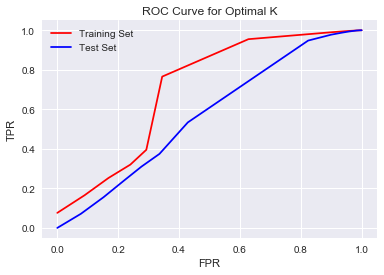

Confusion Matrix on training Data
[[  138  8395]
 [   48 44082]]
AxesSubplot(0.125,0.125;0.62x0.755)


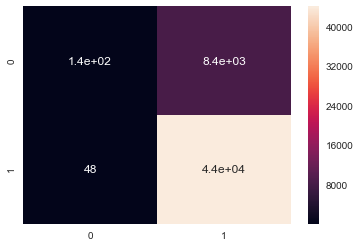

In [91]:
auc_scoreTFIDF_kd_train = roc_auc_score(Y_train, TFIDF_kdpred_train)
print("AUC of train data for K=15 = " + str(auc_scoreTFIDF_kd_train))

auc_scoreTFIDF_kd_test = roc_auc_score(Y_test, TFIDF_kdpred_test)
print("AUC of test data for K=15 = " + str(auc_scoreTFIDF_kd_test))

plt.plot(TFIDF_kdfpr_train,TFIDF_kdtpr_train,'r', label="Training Set")
plt.plot(TFIDF_kdfpr_test,TFIDF_kdtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for Optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

cm_train = confusion_matrix(Y_train,TFIDF_kdpred_train_val)


print("Confusion Matrix on training Data")
print(cm_train)

print(sns.heatmap(cm_train, annot = True))


Confusion Matrix on training Data
[[   30  2791]
 [   12 14722]]
AxesSubplot(0.125,0.125;0.62x0.755)


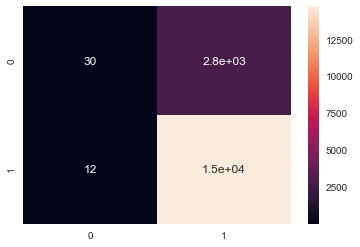

In [92]:
cm_test = confusion_matrix(Y_test,TFIDF_kdpred_test_val)


print("Confusion Matrix on training Data")
print(cm_test)

print(sns.heatmap(cm_test, annot = True))


### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [93]:

hyperparameter_Avg_W2V_kd = []

auc_scoresAvg_W2V_kd_train = []


auc_scoresAvg_W2V_kd_cv = []

table1_Avg_W2V_kd = PrettyTable()

table1_Avg_W2V_kd.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]

#print(type(sent_vectors_train))
#print(str(len(sent_vectors_train)))

#running cross-validation for optimal K

for i in tqdm(range(1,35,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i, algorithm = 'kd_tree')
    
    knn.fit(sent_vectors_train, Y_train)
    
    #Avg_W2Vpred_train = []
    
    #for k in range(0,len(sent_vectors_train), 3000):
        
    Avg_W2Vpred_kd_train = knn.predict_proba(sent_vectors_train)[:,1]
        
   # Avg_W2Vpred_cv = []
    
   # for l in range(0,len(sent_vectors_cv), 3000):
        
    Avg_W2Vpred_kd_cv = knn.predict_proba(sent_vectors_cv)[:,1]
    
    hyperparameter_Avg_W2V_kd.append(i)
    
    auc_scoreAvg_W2V_kd_train = roc_auc_score(Y_train, Avg_W2Vpred_kd_train)
    auc_scoresAvg_W2V_kd_train.append(auc_scoreAvg_W2V_kd_train)
    
    auc_scoreAvg_W2V_kd_cv = roc_auc_score(Y_cv, Avg_W2Vpred_kd_cv)
    auc_scoresAvg_W2V_kd_cv.append(auc_scoreAvg_W2V_kd_cv)
    
    table1_Avg_W2V_kd.add_row([i,auc_scoreAvg_W2V_kd_train, auc_scoreAvg_W2V_kd_cv])

    




100%|███████████████████████████████████████████████████████████████| 17/17 [2:45:03<00:00, 578.00s/it]


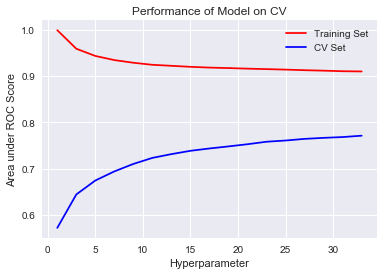

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9992855173722185 | 0.5716731671222655 |
|       3        | 0.959162588114142  | 0.6439817690705383 |
|       5        | 0.9435547650158093 | 0.6741418663669777 |
|       7        | 0.9346274745872046 | 0.693844957360995  |
|       9        |  0.92885501720052  | 0.7100061662901019 |
|       11       | 0.9244302076296796 | 0.7230729058487192 |
|       13       | 0.9222576423083743 | 0.7312138066103091 |
|       15       | 0.9200545826152234 | 0.738379338811534  |
|       17       | 0.9183876056405053 | 0.7434336840165647 |
|       19       | 0.917340163934535  | 0.7478998611203713 |
|       21       | 0.9161109457108562 | 0.7526206132492472 |
|       23       | 0.9150870499726618 | 0.7580112895419296 |
|       25       | 0.9140351667586438 | 0.7606446321428716 |
|       27       | 0.912

In [40]:
plt.plot(hyperparameter_Avg_W2V_kd, auc_scoresAvg_W2V_kd_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_Avg_W2V_kd, auc_scoresAvg_W2V_kd_cv, 'blue', label = 'CV Set')
plt.title("Performance of Model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_Avg_W2V_kd)

In [41]:

print("from the plot the optimal K is 33")
print("AUC for training set for K = 33: " + str(auc_scoresAvg_W2V_kd_train[16]))
print("AUC for CV set for K =33: " + str(auc_scoresAvg_W2V_kd_cv[16]))



knn = KNeighborsClassifier(n_neighbors = 33,  algorithm = 'kd_tree')

knn.fit(sent_vectors_train, Y_train)

#Avg_W2Vpred_train = []
#Avg_W2Vpred_train_val = []

#for m in tqdm(range(0, len(sent_vectors_train),3000)):
    
#    Avg_W2Vpred_train.extend(knn.predict_proba(sent_vectors_train[m:m+3000])[:,1])
#    Avg_W2Vpred_train_val.extend(knn.predict(sent_vectors_train[m:m+3000]))
    
    
Avg_W2Vpred_kd_train = knn.predict_proba(sent_vectors_train)[:,1]
Avg_W2Vpred_kd_train_val = knn.predict(sent_vectors_train)

#Avg_W2Vpred_test = []
#Avg_W2Vpred_test_val = []

#for n in tqdm(range(0, len(sent_vectors_test),3000)):

#    Avg_W2Vpred_test.extend(knn.predict_proba(sent_vectors_test[n:n+3000])[:,1])
#    Avg_W2Vpred_test_val.extend(knn.predict(sent_vectors_test[n:n+3000]))

Avg_W2Vpred_kd_test = knn.predict_proba(sent_vectors_test)[:,1]
Avg_W2Vpred_kd_test_val = knn.predict(sent_vectors_test)    
    
Avg_W2Vfpr_kd_train, Avg_W2Vtpr_kd_train, Avg_W2Vthrshold_kd_train = roc_curve(Y_train, Avg_W2Vpred_kd_train)

Avg_W2Vfpr_kd_test, Avg_W2Vtpr_kd_test, Avg_W2Vthrshold_kd_test = roc_curve(Y_test, Avg_W2Vpred_kd_test)


################################################################################################



from the plot the optimal K is 33
AUC for training set for K = 33: 0.9100546474121118
AUC for CV set for K =33: 0.7710784133828622


AUC of train data for K= = 0.9100546474121118
AUC of test data for K= = 0.7522072381088394


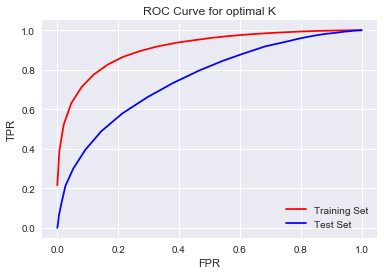

Confusion Matrix on training Data
[[ 2616  5917]
 [  648 43482]]
AxesSubplot(0.125,0.125;0.62x0.755)


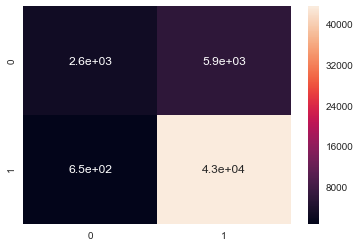

In [94]:
auc_scoreAvg_W2V_kd_train = roc_auc_score(Y_train, Avg_W2Vpred_kd_train)
print("AUC of train data for K= = " + str(auc_scoreAvg_W2V_kd_train))

auc_scoreAvg_W2V_kd_test = roc_auc_score(Y_test, Avg_W2Vpred_kd_test)
print("AUC of test data for K= = " + str(auc_scoreAvg_W2V_kd_test))


plt.plot(Avg_W2Vfpr_kd_train,Avg_W2Vtpr_kd_train,'r', label="Training Set")
plt.plot(Avg_W2Vfpr_kd_test,Avg_W2Vtpr_kd_test, 'blue', label = "Test Set")
plt.title("ROC Curve for optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

cm_train = confusion_matrix(Y_train,Avg_W2Vpred_kd_train_val)


print("Confusion Matrix on training Data")
print(cm_train)

print(sns.heatmap(cm_train, annot = True))

Confusion Matrix on test Data
[[  444  2377]
 [  407 14327]]
AxesSubplot(0.125,0.125;0.62x0.755)


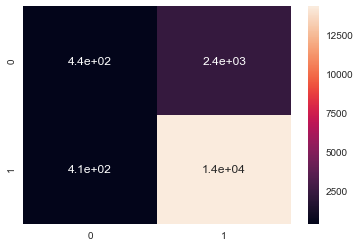

In [95]:
cm_test = confusion_matrix(Y_test,Avg_W2Vpred_kd_test_val)


print("Confusion Matrix on test Data")
print(cm_test)

print(sns.heatmap(cm_test, annot = True))

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [2:23:41<00:00, 506.34s/it]


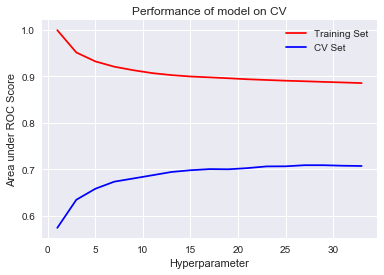

+----------------+--------------------+--------------------+
| Hyperparameter |     AUC_Train      |       AUC_CV       |
+----------------+--------------------+--------------------+
|       1        | 0.9992941176470589 | 0.5741432912942153 |
|       3        | 0.9514022624741766 | 0.6346014518076499 |
|       5        | 0.9321962529186664 | 0.6582586261330197 |
|       7        | 0.9207688735979414 | 0.6735537836411355 |
|       9        | 0.9131945746439327 | 0.6804109598945368 |
|       11       | 0.9069508878206537 | 0.6873428353147873 |
|       13       | 0.9027279303542625 | 0.6943655571649263 |
|       15       | 0.8997250519798978 | 0.698080210926636  |
|       17       | 0.8978496785304707 |  0.70056685328404  |
|       19       | 0.895904658011564  | 0.7001715224941015 |
|       21       | 0.8937923814318881 | 0.7026916041462316 |
|       23       | 0.8922180997934123 | 0.7063266061104136 |
|       25       | 0.8906819109954965 | 0.7065360867228526 |
|       27       | 0.889

In [38]:
# Please write all the code with proper documentation


hyperparameter_TFIDF_W2V_kd = []

auc_scoresTFIDF_W2V_kd_train = []


auc_scoresTFIDF_W2V_kd_cv = []

table1_TFIDF_W2V_kd = PrettyTable()

table1_TFIDF_W2V_kd.field_names = ["Hyperparameter", "AUC_Train", "AUC_CV"]
#print(type(tfidf_sent_vectors_train))
#print(str(len(tfidf_sent_vectors_train)))


for i in tqdm(range(1,35,2)):
  
    knn = KNeighborsClassifier( n_neighbors = i, algorithm = 'kd_tree')
    
    knn.fit(tfidf_sent_vectors_train, Y_train)
       
    TFIDF_W2V_kdpred_train = knn.predict_proba(tfidf_sent_vectors_train)[:,1]
        
    TFIDF_W2V_kdpred_cv = knn.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    hyperparameter_TFIDF_W2V_kd.append(i)
    
    auc_scoreTFIDF_W2V_kd_train = roc_auc_score(Y_train, TFIDF_W2V_kdpred_train)
    auc_scoresTFIDF_W2V_kd_train.append(auc_scoreTFIDF_W2V_kd_train)
    
    auc_scoreTFIDF_W2V_kd_cv = roc_auc_score(Y_cv, TFIDF_W2V_kdpred_cv)
    auc_scoresTFIDF_W2V_kd_cv.append(auc_scoreTFIDF_W2V_kd_cv)
    
    table1_TFIDF_W2V_kd.add_row([i,auc_scoreTFIDF_W2V_kd_train, auc_scoreTFIDF_W2V_kd_cv])

    
plt.plot(hyperparameter_TFIDF_W2V_kd, auc_scoresTFIDF_W2V_kd_train, 'r',label = 'Training Set')
plt.plot( hyperparameter_TFIDF_W2V_kd, auc_scoresTFIDF_W2V_kd_cv, 'blue', label = 'CV Set')
plt.title("Performance of model on CV")
plt.xlabel("Hyperparameter")
plt.ylabel("Area under ROC Score")
plt.legend()
plt.show()

print(table1_TFIDF_W2V_kd)



In [43]:
print("from the plot the optimal K is 27")
print("AUC for training set for K = 27: " + str(auc_scoresTFIDF_W2V_kd_train[13]))
print("AUC for CV set for K = 27: " + str(auc_scoresTFIDF_W2V_kd_cv[13]))



knn = KNeighborsClassifier(n_neighbors = 27, algorithm = 'kd_tree')

knn.fit(tfidf_sent_vectors_train, Y_train)

TFIDF_W2V_kdpred_train = knn.predict_proba(tfidf_sent_vectors_train)[:,1]
TFIDF_W2V_kdpred_train_val = knn.predict(tfidf_sent_vectors_train)

TFIDF_W2V_kdpred_test = knn.predict_proba(tfidf_sent_vectors_test)[:,1]
TFIDF_W2V_kdpred_test_val = knn.predict(tfidf_sent_vectors_test)

TFIDF_W2V_kdfpr_train, TFIDF_W2V_kdtpr_train, TFIDF_W2V_kdthrshold_train = roc_curve(Y_train, TFIDF_W2V_kdpred_train)

TFIDF_W2V_kdfpr_test, TFIDF_W2V_kdtpr_test, TFIDF_W2V_kdthrshold_test = roc_curve(Y_test, TFIDF_W2V_kdpred_test)



from the plot the optimal K is 27
AUC for training set for K = 27: 0.8894842142277739
AUC for CV set for K = 27: 0.7089312680903572


AUC of train data for K= 27 = 0.8894842142277739
AUC of test data for K= 27 = 0.7010231129845086


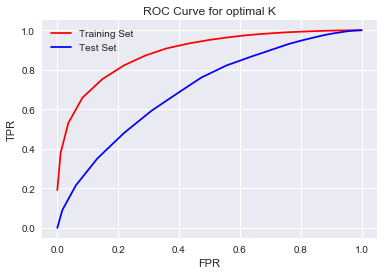

Confusion Matrix on training Data
[[ 2408  6092]
 [  617 43546]]
AxesSubplot(0.125,0.125;0.62x0.755)


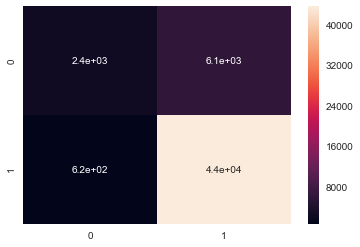

In [44]:
auc_scoreTFIDF_W2V_kd_train = roc_auc_score(Y_train, TFIDF_W2V_kdpred_train)
print("AUC of train data for K= 27 = " + str(auc_scoreTFIDF_W2V_kd_train))

auc_scoreTFIDF_W2V_kd_test = roc_auc_score(Y_test, TFIDF_W2V_kdpred_test)
print("AUC of test data for K= 27 = " + str(auc_scoreTFIDF_W2V_kd_test))

plt.plot(TFIDF_W2V_kdfpr_train,TFIDF_W2V_kdtpr_train,'r', label="Training Set")
plt.plot(TFIDF_W2V_kdfpr_test,TFIDF_W2V_kdtpr_test, 'blue', label = "Test Set")
plt.title("ROC Curve for optimal K")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

cm_train = confusion_matrix(Y_train,TFIDF_W2V_kdpred_train_val)

print("Confusion Matrix on training Data")
print(cm_train)

print(sns.heatmap(cm_train, annot = True))



Confusion Matrix on test Data
[[  360  2506]
 [  373 14316]]
AxesSubplot(0.125,0.125;0.62x0.755)


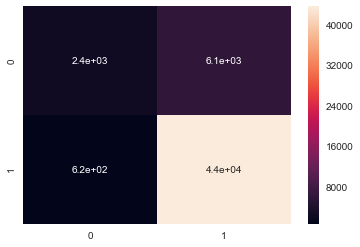

In [41]:
cm_test = confusion_matrix(Y_test,TFIDF_W2V_kdpred_test_val)

print("Confusion Matrix on test Data")
print(cm_test)

print(sns.heatmap(cm_train, annot = True))

# [6] Conclusions

In [42]:
# Please compare all your models using Prettytable library

cmpTable = PrettyTable()

cmpTable.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

cmpTable.add_row(["BOW", "Brute",33,0.68])
cmpTable.add_row(["TFIDF", "Brute",31,0.50])
cmpTable.add_row(["Avg W2V", "Brute",33,0.75])
cmpTable.add_row(["TFIDF W2V", "Brute",31,0.74])
cmpTable.add_row(["BOW", "KDTree",33,0.75])
cmpTable.add_row(["TFIDF", "KDTree",25,0.56])
cmpTable.add_row(["Avg W2V", "KDTree",33,0.75])
cmpTable.add_row(["TFIDF W2V", "KDTree",27,0.70])
                             
print("Comparison Table:")
    
print(cmpTable)

Comparison Table:
+------------+--------+----------------+------+
| Vectorizer | Model  | Hyperparameter | AUC  |
+------------+--------+----------------+------+
|    BOW     | Brute  |       33       | 0.68 |
|   TFIDF    | Brute  |       31       | 0.5  |
|  Avg W2V   | Brute  |       33       | 0.75 |
| TFIDF W2V  | Brute  |       31       | 0.74 |
|    BOW     | KDTree |       33       | 0.75 |
|   TFIDF    | KDTree |       25       | 0.56 |
|  Avg W2V   | KDTree |       33       | 0.75 |
| TFIDF W2V  | KDTree |       27       | 0.7  |
+------------+--------+----------------+------+
